This notebook is a summary of Familiar session clustering control. I use the same steps as in original clustering analysis to examine clusters in the data from 3 Familiar sessions only in cells that were matched across at least 3 matched sessions. 

Two interesting questions that we can answer by looking at these clusters:
* Are the clusters from Familiar sessions only different from F/N/N+ dataset?
* What are the rates of represetional drift across Familiar sessions in three cre lines?

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook', font_scale=1.5, rc={'lines.markeredgewidth': 2})

In [2]:
import visual_behavior.data_access.utilities as utilities
from visual_behavior.data_access import loading as loading
import visual_behavior.dimensionality_reduction.clustering as vba_clust

In [3]:
import visual_behavior_glm.GLM_params as glm_params
import visual_behavior_glm.GLM_analysis_tools as gat
import visual_behavior_glm.GLM_fit_dev as glm_fit

In [4]:
import visual_behavior.visualization.utils as utils
from visual_behavior.dimensionality_reduction.clustering import plotting
from visual_behavior.dimensionality_reduction.clustering import processing

In [5]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering as ac

In [6]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


In [7]:
glm_version = '24_events_all_L2_optimize_by_session'
model_output_type = 'adj_fraction_change_from_full'

base_dir = r'\\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_plots\figure_4'
base_dir = os.path.join(base_dir, glm_version)
if not os.path.exists(base_dir):
    os.mkdir(base_dir)
    
folder = '220922_familiar_control'
save_dir = os.path.join(base_dir, folder)
if not os.path.exists(save_dir):
    os.mkdir(save_dir)
    

In [8]:
dropout_features = ['all-images', 'omissions', 'behavioral', 'task']

## Load GLM results and select familiar sessions only

In [9]:
cells_table = loading.get_cell_table(platform_paper_only=True, limit_to_closest_active=False, limit_to_matched_cells=False, add_extra_columns=True)
print(len(cells_table.ophys_experiment_id.unique()), 'expts in cells table')
print(len(cells_table.cell_specimen_id.unique()), 'unique cell_specimen_ids in cells table')

1248 expts in cells table
28806 unique cell_specimen_ids in cells table


In [10]:
filename = os.path.join(save_dir, 'feature_matrix_familiar_only.h5')
if os.path.exists(filename):
    feature_matrix = pd.read_hdf(filename, key = 'df')
    print('loaded feature matrix.')
# load and reshape file
else:
    run_params, results, results_pivoted, weights_df = glm_fit.get_analysis_dfs(glm_version)
    # select correct sessions
    active_only = results_pivoted[results_pivoted.session_type.isin(['OPHYS_1_images_B','OPHYS_3_images_B','OPHYS_1_images_A','OPHYS_3_images_A'])]
    # count how many cells have >= 3 sessions
    tmp = active_only.groupby('cell_specimen_id').count()[['session_type']]
    matched_cell_ids = tmp[tmp['session_type']>=3].index.values
    print('found {} cells...'.format(len(matched_cell_ids)))
    
    # drop cells that do not have at least 3 imaging sessions
    selected_sessions = active_only[active_only.cell_specimen_id.isin(matched_cell_ids)]
    # sort by date of imaging
    selected_sessions = selected_sessions.sort_values('date_of_acquisition')
    
    # rename session numbers to be sequential. Since there shouldnt be any difference among the sessions, we can just enumerate them.
    # I'm not going to create another column for this, since we already have "session_number" column. I will just replace those values
    for cid in matched_cell_ids:
        tmp = selected_sessions[selected_sessions.cell_specimen_id == cid]
        count = 1
        for index in tmp.index.values:
            selected_sessions.at[index, 'session_number'] = count
            count =count+1
    
    # group by cell id and session number
    feature_matrix = selected_sessions.groupby(['cell_specimen_id', 'session_number']).sum()[dropout_features].unstack()
    # drop cells with nan
    feature_matrix = feature_matrix.dropna(axis=1)
    
    # save
    feature_matrix.to_hdf(filename, key = 'df')

loaded feature matrix.


In [11]:
len(np.unique(feature_matrix.index.values))

1450

In [12]:
cre_lines = np.sort(cells_table.cre_line.unique())
cells_table_sel = cells_table[cells_table.cell_specimen_id.isin(feature_matrix.index.values)]

In [13]:
# separate feature matrix by cre line
cre_line_dfs = {}
for cre_line in cre_lines:
    cids = np.unique(cells_table_sel[cells_table_sel['cre_line']==cre_line]['cell_specimen_id'].values)
    print(cre_line,len(cids))
    df_cre = feature_matrix.loc[cids].copy()
    cre_line_dfs[cre_line] = df_cre

Slc17a7-IRES2-Cre 1163
Sst-IRES-Cre 149
Vip-IRES-Cre 138


## Find optimal number of clusters

### Compute eigen gap

Optimal number of clusters [   2    1    4    6    5    3    9   10    8    7 1160   13   11 1162
   15   12 1161 1158   16 1159   20   14   21   18   17]
Optimal number of clusters [  1   2   3   5 148   4   8   6   7 145 144   9 141 138 137  12 140  15
  19  16  13 130  18 127  11]
Optimal number of clusters [  1   3   4   2   5   7 137  10  13 136  12  11  16 135   8  18  15  23
   6  14 128  22  21  20 134]


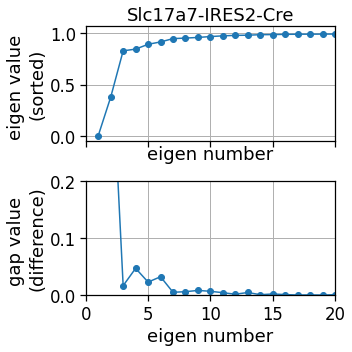

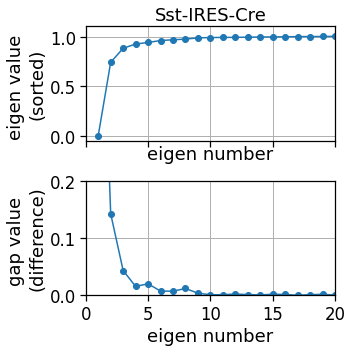

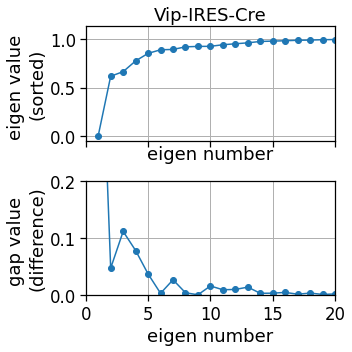

In [14]:
from sklearn.cluster import SpectralClustering

eigenGap_df = {}
for i, cre_line in enumerate(cre_lines):
    X = cre_line_dfs[cre_line].values
    sc = SpectralClustering()
    sc.fit(X)
    A = sc.affinity_matrix_
    
    eigenvalues, eigenvectors, nb_clusters = vba_clust.get_eigenDecomposition(A)
    
    fig, ax = plt.subplots(2,1, figsize = (5,5), sharex=True)
    ax[0].plot(np.arange(1,len(eigenvalues)+1), eigenvalues, '-o')
    ax[0].grid()
    ax[0].set_title(cre_line)
    ax[0].set_ylabel('eigen value \n(sorted)')
    ax[0].set_xlabel('eigen number')
    ax[0].set_xlim([0, 20])
    #ax[0].set_xticks([np.arange(2,20,step = 2)])
    
    ax[1].plot(np.arange(1,len(eigenvalues)), np.diff(eigenvalues), '-o')
    ax[1].set_ylabel('gap value \n(difference)')
    ax[1].set_xlabel('eigen number')
    ax[1].set_xlim([0, 20])
    ax[1].set_ylim([0, 0.20])
    ax[1].grid()
    plt.tight_layout()
    fig.savefig(os.path.join(save_dir, f'eigenGap_{cre_line}.png'))
    eigenGap_df[cre_line] = [ eigenvalues, eigenvectors, nb_clusters]
    print(f'Optimal number of clusters {nb_clusters}')
        
    

### Compute Gap statistic

In [15]:
import pickle

metric = 'euclidean' # default distance metric
shuffle_type ='all' # default shuffle type is all shuffle (cell id and regressors

gap_filename = os.path.join(save_dir, 'gap_scores_{}_{}_nb20_unshuffled_to_{}.pkl'.format(metric, glm_version, shuffle_type))
if os.path.exists(gap_filename):
    with open(gap_filename, 'rb') as f:
        gap_df = pickle.load(f)
        print('loaded file')
else:
    gap_df = {}
    for i, cre_line in enumerate(cre_lines):
        X = cre_line_dfs[cre_line]
        sc = SpectralClustering()
        gap_statistics = vba_clust.compute_gap(sc, X, k_max = 25)
        gap_df[cre_line]= gap_statistics
    vba_clust.save_clustering_results(gap_df, gap_filename)

loaded file


In [16]:
gap_df[cre_line].keys()

dict_keys(['gap', 'reference_inertia', 'ondata_inertia', 'reference_sem', 'ondata_sem', 'gap_mean', 'gap_sem'])

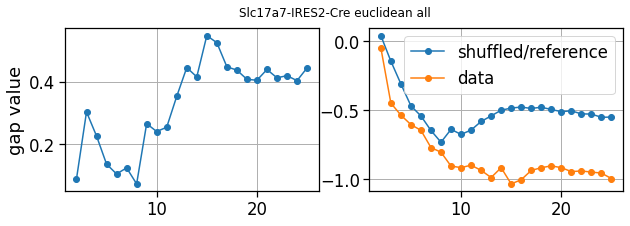

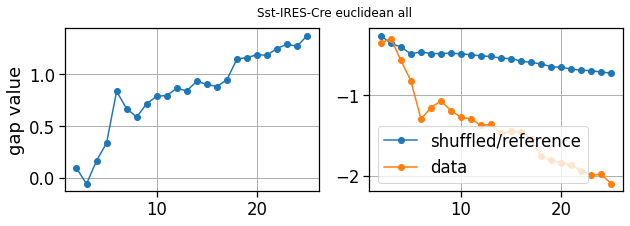

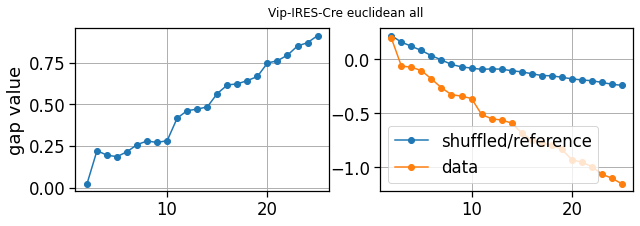

In [17]:
# plot gap statistic

for cre_line in cre_lines:
    fig, ax = plt.subplots(1,2, figsize = (10,3))
    x = len(gap_df[cre_line]['gap'])
    ax[0].plot(np.arange(2,x+2), gap_df[cre_line]['gap'], 'o-')
    ax[0].set_ylabel('gap value')
    ax[0].grid()
    ax[1].plot(np.arange(2,x+2),gap_df[cre_line]['reference_inertia'], 'o-')
    ax[1].plot(np.arange(2,x+2),gap_df[cre_line]['ondata_inertia'], 'o-')
    ax[1].legend(['shuffled/reference', 'data'])
    ax[1].grid()
    plt.suptitle(cre_line + ' ' + metric + ' ' + shuffle_type)
    fig.savefig(os.path.join(save_dir, 'Gap_nb20_{}_{}_unshuffled_to_{}.png'.format(cre_line, metric, shuffle_type)))


**Discussion**: From examining the plots above, it seems like the original number of clusters: 10, 5, 10 for threee cre lines may not the the most optimal. We can first cluster familiar sessions with ogiinal number of N for easy comparison and then cluster with a different more optimal number.

## Cluster the data, 10 - 5 - 10

### Compute coclustering matrix

In [18]:
n_clusters_cre = [10,5,10]

In [19]:
import pickle
filename = os.path.join(save_dir, 'coClustering_matrix.pkl')
if os.path.exists(filename):
    print('loading file...')
    with open(filename, 'rb') as f:
        coclustering_matrices  = pickle.load(f)
        f.close()
        print('done.')
else:
    n_clusters_cre = [10,5,10] # these n clusters are based on old sil plots
    coclustering_matrices = {}
    for i, cre_line in enumerate(cre_lines):
        X = cre_line_dfs[cre_line].values
        m = vba_clust.get_coClust_matrix(X=X,n_clusters=n_clusters_cre[i], nboot=np.arange(50))
        coclustering_matrices[cre_line]=m
    vba_clust.save_clustering_results(coclustering_matrices, filename)

loading file...
done.


#### Assign labels based on agglomerative clustering

In [20]:
labels_cre={}
for i,cre_line in enumerate(cre_lines):
    X = coclustering_matrices[cre_line]
    cluster = ac(n_clusters=n_clusters_cre[i], affinity='euclidean', linkage='average')
    labels_cre[cre_line] = cluster.fit_predict(X)

#### Plot Coclustering matrix

C:\Users\iryna.yavorska\Anaconda3\envs\vba\lib\site-packages\seaborn\matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


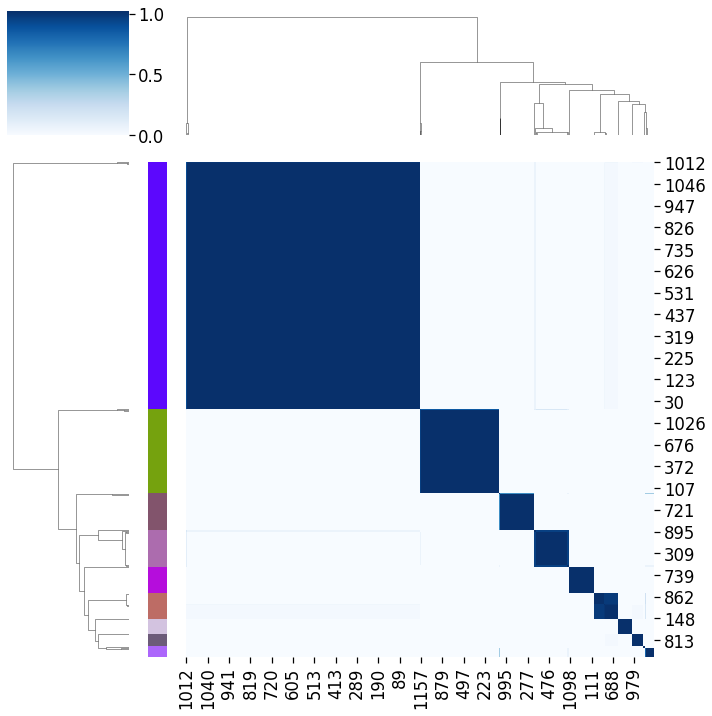

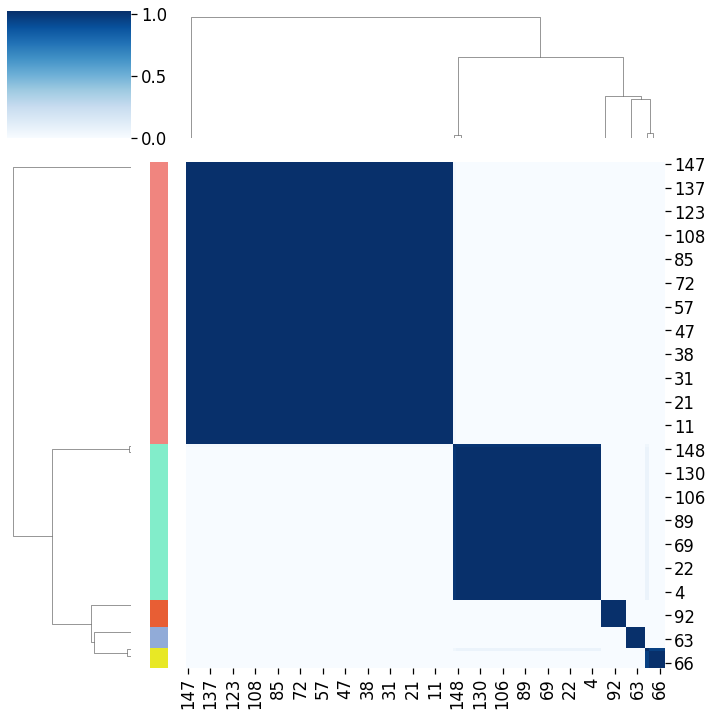

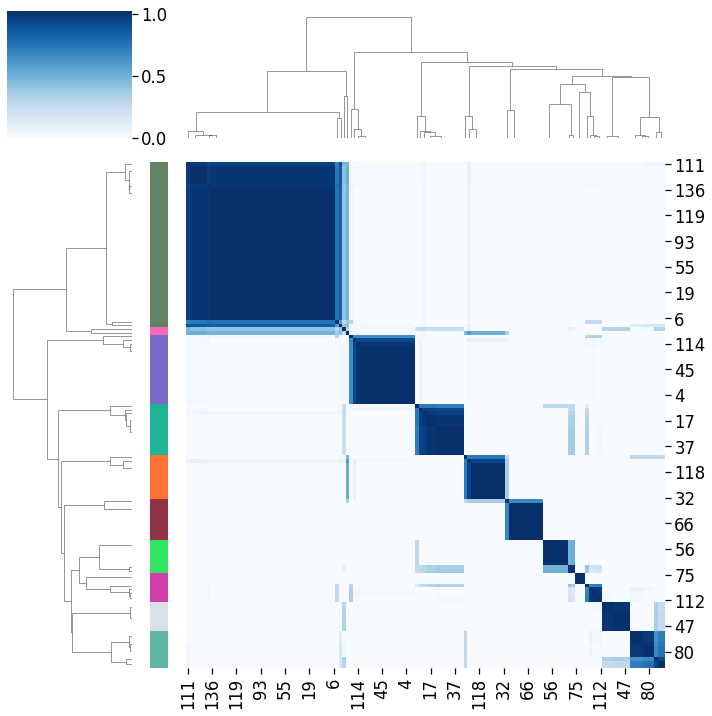

In [21]:
for i, cre_line in enumerate(cre_lines):
    labels = labels_cre[cre_line] 
    row_colors = vba_clust.get_cluster_colors(labels)
    fig = sns.clustermap(coclustering_matrices[cre_line], cmap = 'Blues', row_colors = row_colors)
    plt.tight_layout()
    fig.savefig(os.path.join(save_dir, 'Clustermap_{}_{}_nc{}.png'.format(cre_line, 
                                                                    glm_version,
                                                                    n_clusters_cre[i])))
    

### Plot cluster dropout scores

In [71]:
save_dir

'\\\\allen\\programs\\braintv\\workgroups\\nc-ophys\\visual_behavior\\platform_paper_plots\\figure_4\\24_events_all_L2_optimize_by_session\\220922_familiar_control'

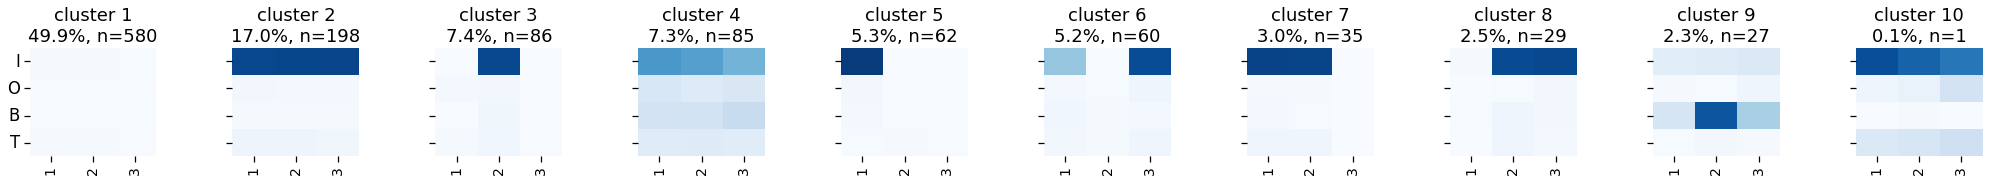

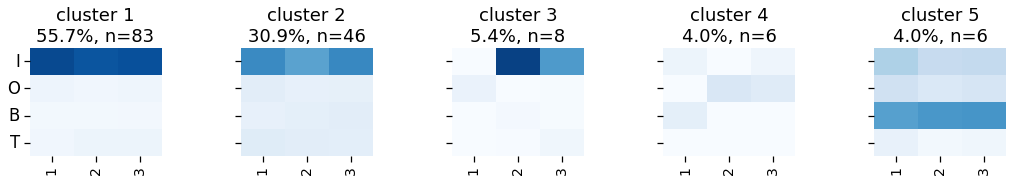

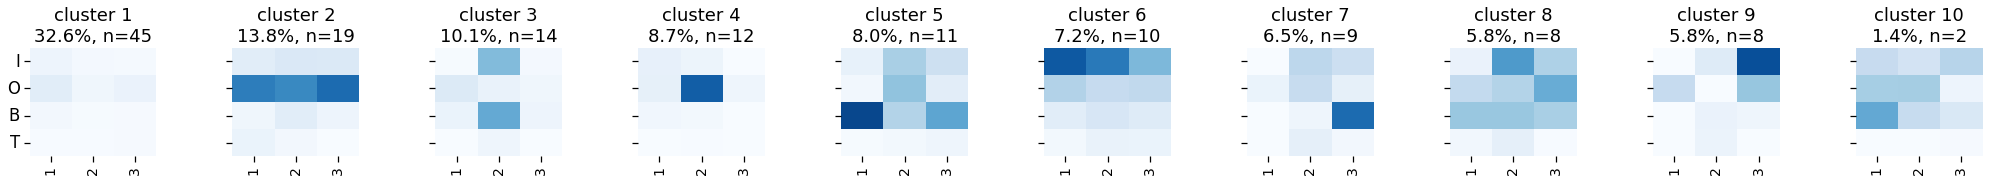

In [70]:

sort_order = {}
for i, cre_line in enumerate(cre_lines):
    tmp = np.abs(cre_line_dfs[cre_line])
    labels = labels_cre[cre_line] 
    cluster_df = pd.DataFrame(index = tmp.index.values, columns = ['cluster_id', 'cre_line'], 
                              data = np.transpose([labels+1, [cre_line]* len(labels)]))
    sort_order[cre_line] = vba_clust.get_sorted_cluster_ids(cluster_df)
    #rename cluster after sorting by their size
    cl_dict = {}
    for i, cl in enumerate(sort_order[cre_line]):
        cl_dict[cl]=i+1
    cluster_df = cluster_df.replace(cl_dict)
    
    vba_clust.plot_clusters_row(cluster_df, tmp, cre_line,
                               save_dir=save_dir, folder='', suffix=f'_familiar_only_{n_clusters_cre}',
                                 abbreviate_experience=False)


### Plot area and depth analysis

In [23]:
## add cluster id
cells_table_sel = cells_table_sel.drop_duplicates('cell_specimen_id')
cells_table_sel = cells_table_sel.set_index('cell_specimen_id')
df_meta = cells_table_sel.copy()
for cre_line in cre_lines:
    labels = labels_cre[cre_line] 
    index = cre_line_dfs[cre_line].index.values
    df_meta.at[index, 'cluster_id'] = labels+1
    
    


In [24]:
# this plot doesnt work without multi_session_df

for cre_line in cre_lines:
    vba_clust.plot_clusters_stats_pop_avg_rows(df_meta, feature_matrix, multi_session_df=None, cre_line = cre_line,
                                     columns_to_groupby=['targeted_structure'], change=False, omitted=True,
                                     sort_order=None, save_dir=save_dir, folder='areas', suffix='', alpha=None)


AttributeError: 'NoneType' object has no attribute 'merge'

## Cluster the data, 6 - 5 - 7

### Compute coclustering matrix

In [ ]:
n_clusters_cre = [6,5,7]

In [ ]:
filename = os.path.join(save_dir, f'coClustering_matrix_{n_clusters_cre}.pkl')
if os.path.exists(filename):
    print('loading file...')
    with open(filename, 'rb') as f:
        coclustering_matrices  = pickle.load(f)
        f.close()
        print('done.')
else:
    coclustering_matrices = {}
    for i, cre_line in enumerate(cre_lines):
        X = cre_line_dfs[cre_line].values
        print(n_clusters_cre[i])
        m = vba_clust.get_coClust_matrix(X=X,n_clusters=n_clusters_cre[i], nboot=np.arange(50))
        coclustering_matrices[cre_line]=m
    vba_clust.save_clustering_results(coclustering_matrices, filename)

#### Assign labels based on agglomerative clustering

In [ ]:
labels_cre={}
for i,cre_line in enumerate(cre_lines):
    X = coclustering_matrices[cre_line]
    print(n_clusters_cre[i])
    cluster = ac(n_clusters=n_clusters_cre[i], affinity='euclidean', linkage='average')
    labels_cre[cre_line] = cluster.fit_predict(X)

#### Plot Coclustering matrix

In [ ]:
for i, cre_line in enumerate(cre_lines):
    labels = labels_cre[cre_line] 
    row_colors = vba_clust.get_cluster_colors(labels)
    fig = sns.clustermap(coclustering_matrices[cre_line], cmap = 'Blues', row_colors = row_colors)
    plt.tight_layout()
    fig.savefig(os.path.join(save_dir, 'Clustermap_{}_{}_nc{}.png'.format(cre_line, 
                                                                    glm_version,
                                                                    n_clusters_cre[i])))
    

### Plot cluster dropout scores

In [ ]:

sort_order = {}
for c, cre_line in enumerate(cre_lines):
    feature_matrix = cre_line_dfs[cre_line]
    labels = labels_cre[cre_line] 
    cluster_df = pd.DataFrame(index = feature_matrix.index.values, columns = ['cluster_id', 'cre_line'], 
                              data = np.transpose([labels+1, [cre_line]* len(labels)]))
    #cluster_df = original_cluster_labels[original_cluster_labels.cre_line == cre_line].set_index('cell_specimen_id')
    sort_order[cre_line] = vba_clust.get_sorted_cluster_ids(cluster_df)
    vba_clust.plot_clusters_row(cluster_df, feature_matrix, cre_line,
                               sort_order=sort_order, save_dir=save_dir, folder='test', suffix=f'_familiar_only_{n_clusters_cre[c]}',
                                 abbreviate_experience=False)


In [ ]:
### pot mean of shuffled dropout scores regardless of clusters.
import visual_behavior_glm.GLM_clustering as glm_clust
figsize = (10,3.5)

fig, ax = plt.subplots(1,3, figsize = figsize, sharey='row')
for c, cre_line in enumerate(cre_lines):
    feature_matrix = cre_line_dfs[cre_line]
    mean_df = feature_matrix.mean().unstack()
    features = vba_clust.get_features_for_clustering()
    mean_df = mean_df.loc[features]
    ax[c] = sns.heatmap(mean_df.abs(), cmap='Blues', ax=ax[c], vmin=0, vmax=0.5)
    ax[c].set_title(glm_clust.mapper(cre_line))
plt.tight_layout()
utils.save_figure(fig, figsize = figsize, save_dir=save_dir, folder='', fig_title=f'mean_dropout_scores_familiar_only')

In [ ]:
feature_matrix.mean()

## Comapring clusters in Familiar and Original data

In [ ]:
Compare size of matched clusters
Find the same cells and see where they move to (which cluster)

In [ ]:
familiar_cluster_labels = df_meta.reset_index()[['cell_specimen_id', 'cre_line', 'cluster_id']].copy()
familiar_cluster_labels

In [ ]:
### load original data clusters
file_dir = '220627_shuffle_test/files'
filename = 'cluster_labels_Vip_10_Sst_5_Slc17a7_10.h5'
base_dir = r'//allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_plots/figure_4'
base_dir = os.path.join(base_dir, glm_version)
original_cluster_labels = pd.read_hdf(os.path.join(base_dir, file_dir, filename))
original_cluster_labels = original_cluster_labels.reset_index(drop=True)
original_cluster_labels

In [ ]:
familiar_cids = familiar_cluster_labels['cell_specimen_id'].values
original_cids = original_cluster_labels['cell_specimen_id'].values
print(len(np.intersect1d(familiar_cids, original_cids)))
overlapping_cids = np.intersect1d(familiar_cids, original_cids)

In [ ]:
familiar_selected = familiar_cluster_labels[familiar_cluster_labels['cell_specimen_id'].isin(overlapping_cids)]
original_selected = original_cluster_labels[original_cluster_labels['cell_specimen_id'].isin(overlapping_cids)]

In [ ]:
# save dataframes
familiar_selected.to_hdf(os.path.join(save_dir, 'fa_matched_labels.h5'), key = 'df')
original_selected.to_hdf(os.path.join(save_dir, 'og_matched_labels.h5'), key = 'df')


In [ ]:
for cre_line in [cre_lines[2]]:
    tmp1 = original_selected[original_selected.cre_line==cre_line]
    tmp2 = familiar_selected[familiar_selected.cre_line==cre_line]

In [ ]:
# create one df
cluster_df = tmp2.join(tmp1.set_index('cell_specimen_id'), on='cell_specimen_id', lsuffix='_familiar')

In [ ]:
# convert cluster ids to str
cluster_df['cluster_id'] = cluster_df['cluster_id'].apply(str)
cluster_df['cluster_id_familiar'] = cluster_df['cluster_id_familiar'].apply(str)

In [ ]:
# create variable for between cluster links
cluster_df['cluster_combos']=cluster_df['cluster_id']+ '_' + cluster_df['cluster_id_familiar']

In [ ]:
# convert df to unique cluster combo count
cluster_df_unique = cluster_df.groupby('cluster_combos').count()[['labels']]

In [ ]:
# create new columns
cluster_df_unique['familiar_cluster_id']=np.nan
cluster_df_unique['novel_cluster_id']=np.nan

In [ ]:
# new cluster id labels

for index in cluster_df_unique.index:
    x = cluster_df[cluster_df['cluster_combos']==index]['cluster_id_familiar'].values[0]
    cluster_df_unique.loc[index, 'familiar_cluster_id'] = x + '_F'
    x = cluster_df[cluster_df['cluster_combos']==index]['cluster_id'].values[0]
    cluster_df_unique.loc[index, 'novel_cluster_id'] = x + '_N'

In [ ]:
cluster_df_unique['fam_index'] = np.nan
cluster_df_unique['nov_index'] = np.nan


In [ ]:
labels = []
i = 0
for index in cluster_df_unique.index.values:
    labels.append(cluster_df_unique.loc[index, 'familiar_cluster_id'])
for index in cluster_df_unique.index.values:
    labels.append(cluster_df_unique.loc[index, 'novel_cluster_id'])


In [ ]:
unique_labels = np.unique(labels)
label_dict = {}
i = 0
for label in unique_labels:
    label_dict[label] = i
    i+=1

In [ ]:
for index in cluster_df_unique.index.values:
    cluster_df_unique.loc[index, 'fam_index'] = label_dict[cluster_df_unique.loc[index, 'familiar_cluster_id']]
    cluster_df_unique.loc[index, 'nov_index'] = label_dict[cluster_df_unique.loc[index, 'novel_cluster_id']]

In [ ]:
import plotly.graph_objects as go

In [ ]:

fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 1,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = unique_labels,
      color = "blue"
    ),
    link = dict(
      source = cluster_df_unique['fam_index'].values, # 
      target = cluster_df_unique['nov_index'].values,
      value = cluster_df_unique['labels'].values
  ))])

fig.update_layout(title_text="Familiar to Novel", font_size=10, width = 500, height = 1000)
fig.show()

In [ ]:
len(cluster_df_unique['labels'].values)

## Summary